# Plotting 1D distribution of the charm score

In [1]:
import os, subprocess
import json
import uproot3
import awkward as ak
import numpy as np
from coffea import processor, util, hist
import pickle
import pandas as pd

#Plot settings
%matplotlib inline
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
#mpl.rcParams['lines.linewidth'] = 5

from plotter import *

#Dataset parameters
lumis = {}
lumis['2016'] = 35.9
lumis['2017'] = 41.5
lumis['2018'] = 59.9

with open('xsec.json') as f:
    xs = json.load(f)

with open('pmap.json') as f:
    pmap = json.load(f)

systematics = ['nominal',
               'jet_triggerUp','jet_triggerDown',
               'btagWeightUp','btagWeightDown','btagEffStatUp','btagEffStatDown',
               'UESUp','UESDown','JESUp','JESDown','JERUp','JERDown',
              ]

mc = ['QCD','Wjets','Zjets','ttbar','singlet','VV','ggF','VBF','ZH','WH']


#To calculate significance
def significance(s,b):
    if b==0:
        return 0
    z_squared = 2.0*(s+b)*np.log(1.0+1.0*s/b) - 2.0*s
    return np.sqrt(z_squared)

## 1. Processing plots after Jennet's run

Coffea outputs: /eos/uscms/store/user/jennetd/may-2021/vh-charm-category/outfiles

In [2]:
year = '2017'
outsum = processor.dict_accumulator()
nfiles = len(subprocess.getoutput("ls ../infiles-split/"+year+"*.json").split())
#nfiles = 10

# Check if pickle exists, and don't re-create it if it does
repickle=True

picklename = 'pickles/{}_CScores_VHCharmSample.pkl'.format(year)
if os.path.isfile(picklename):
    repickle=False

In [3]:
# Load all files - this takes a while
if repickle:
    for n in range(1, nfiles+1):

        with open('../infiles-split/{}_{}.json'.format(year, n)) as f:
            infiles = json.load(f)
    
        filename = '/myeosdir/vh-charm-category/outfiles-ddb2/{}_{}.coffea'.format(year, n)
        #filename = 'outfiles/'+year+'_'+str(n)+'.coffea' #For local testing
        
        if os.path.isfile(filename):
            try:
                out = util.load(filename)
                outsum.add(out)
            except:
                print("File {} is broken.".format(filename))
        else:
            print('Missing file: '+str(n), infiles.keys())
            #print("File " + filename + " is missing")
        
    scale_lumi = {k: xs[k] * 1000 *lumis[year] / w for k, w in outsum['sumw'].items()}
    outsum['templates-vh-2'].scale(scale_lumi, 'dataset')
    
    # Use pmap to group the datasets together
    templates = outsum['templates-vh-2'].group('dataset', hist.Cat('process', 'Process'), pmap)

    outfile = open(picklename, 'wb')
    pickle.dump(templates, outfile, protocol=-1)
    outfile.close()

In [4]:
# Read the histogram from the pickle file
templates = pickle.load(open(picklename,'rb'))\
                  .sum('msd2','ddb2')\
                  .integrate('region','signal')

## Create the two regions

In [5]:
os.system('rm '+year+'/1-signalregion.root')
fout = uproot3.create(year+'/1-signalregion.root')

for p in pmap.keys():  
    print("Process:", p)
    s = "nominal"
    
    #(QCD pass, QCD fail) x (charm, light)
    
    #--QCD pass, charm
    h = templates.integrate('ddb1',int_range=slice(0.7,1))\
                 .integrate('ddc2',int_range=slice(0.6,1))\
                 .integrate('process',p)
    
    fout["QCDpass_charm_{}_{}".format(p,s)] = hist.export1d(h)
    
    #--QCD fail, charm
    h = templates.integrate('ddb1',int_range=slice(0,0.7))\
                 .integrate('ddc2',int_range=slice(0.6,1))\
                 .integrate('process',p)
    
    fout["QCDfail_charm_{}_{}".format(p,s)] = hist.export1d(h)
    
    #--QCD pass, light
    h = templates.integrate('ddb1',int_range=slice(0.7,1))\
                 .integrate('ddc2',int_range=slice(0,0.6))\
                 .integrate('process',p)
    
    fout["QCDpass_light_{}_{}".format(p,s)] = hist.export1d(h)
    
    #--QCD fail, light
    h = templates.integrate('ddb1',int_range=slice(0,0.7))\
                 .integrate('ddc2',int_range=slice(0,0.6))\
                 .integrate('process',p)
    
    fout["QCDfail_light_{}_{}".format(p,s)] = hist.export1d(h)
    

fout.close()

Process: ZH
Process: WH
Process: ttH
Process: VBF
Process: ggF
Process: ggF-powheg
Process: QCD
Process: VV
Process: Wjets
Process: Zjets
Process: ttbar
Process: singlet
Process: data
Process: muondata


In [9]:
!readlink -f 2017/1-signalregion.root

/srv/vh-category/vh-charm-ddb1/charm_score/2017/1-signalregion.root


In [7]:
!ls 2017

1-signalregion.root


In [13]:
def significance_scaled(s,b):
    
    #s = s*137.3/41.5
    #b = b*137.3/41.5
    
    if b==0:
        return 0
    z_squared = 2.0*(s+b)*np.log(1.0+1.0*s/b) - 2.0*s
    return np.sqrt(z_squared)

def significance_table(templates):
    
    indx = ['>=', '<=', "Quadrature Sum"]
    cols = ["{}".format(round(x,1)) for x in templates.axis('ddc2').edges()]
    edge_vals = templates.axis('ddc2').edges()
    
    significance_df = pd.DataFrame(index = indx, columns = cols)
    
    b_list = [x for x in mc if x not in ['ZH', 'WH']] #Background
    
    for cut in indx:
        for thres in edge_vals:
            
            if cut == '>=': #Integrate forward
                #Calculate the number of signals and background
                s = templates.integrate('process', ['ZH', 'WH']).integrate('ddc2', slice(thres,1)).values()[()]
                b = templates.integrate('process', b_list).integrate('ddc2', slice(thres,1)).values()[()]

                significance_df.loc[cut, "{}".format(round(thres,1))] = significance_scaled(s,b)
                
            else: #Integrate backwards
                #Calculate the number of signals and background
                s = templates.integrate('process', ['ZH', 'WH']).integrate('ddc2', slice(0.,thres)).values()[()]
                b = templates.integrate('process', b_list).integrate('ddc2', slice(0.,thres)).values()[()]

                significance_df.loc[cut, "{}".format(round(thres,1))] = significance_scaled(s,b)
    
    def hypot(x):
        return np.hypot(x[0], x[1])

    significance_df.loc['Quadrature Sum'] = significance_df.apply(hypot, axis = 0)
    
    return significance_df


significance_df = significance_table(templates)

In [14]:
significance_df

,0.0,0.2,0.4,0.6,0.8,1.0
>=,0.883733,1.066747,0.934361,1.03896,0.622812,0
<=,0.098269,0.098269,0.317693,0.489967,0.772735,0.883733
Quadrature Sum,0.88918,1.071263,0.986894,1.148697,0.992478,0.883733


In [63]:
templates.integrate('process', ['ZH', 'WH']).integrate('ddc2', slice(0.,0))

<Hist () instance at 0x7f8f295973a0>

## Plot 2D distribution for different signal processes

In [5]:
templates

<Hist (process,msd1,ddb1,ddc2) instance at 0x7fd0f8e11e50>

In [29]:
def plot_2d_score(signal_p, templates):
    
    h = templates.sum('msd1').integrate('process', signal_p)

    fig, ax = plt.subplots(2,2,sharex='col',sharey='row')
    plt.suptitle(signal_p)

    plt.subplots_adjust(hspace=0)
    plt.subplots_adjust(wspace=0)

    #ax[0,1].set_logy()
    #ax[0,1].set_logx()

    xprojection = hist.export1d(h.integrate('ddc2')).numpy()
    yprojection = hist.export1d(h.integrate('ddb1')).numpy()

    ybins = yprojection[1]
    xbins = xprojection[1]

    ax[1,1].hist(ybins[:-1],
                 weights=yprojection[0],
                 bins=ybins,
                 histtype='step',
                 orientation='horizontal')
    ax[1,1].set_xlabel('Events')

    ax[0,0].hist(xbins[:-1],
                 weights=xprojection[0],
                 bins=xbins,
                 histtype='step')
    ax[0,0].set_ylabel('Events')

    #Remove overlapping ticks 
    yticks_0 = ax[0,0].yaxis.get_major_ticks()
    yticks_0[0].set_visible(False)

    xticks_1 = ax[1,1].xaxis.get_major_ticks()
    xticks_1[0].set_visible(False)

    yticks_01 = ax[0,1].yaxis.get_major_ticks()
    yticks_01[-1].set_visible(False)


    X, Y = np.meshgrid(xbins[:-1],ybins[:-1])
    w = h.values()[()]

    ax[1,0].hist2d(X.flatten(),Y.flatten(),weights=w.flatten(),bins=(xbins, ybins))
    ax[1,0].set_xlabel('Jet 1 DDB Score')
    ax[1,0].set_ylabel('Jet 2 DDCvL')

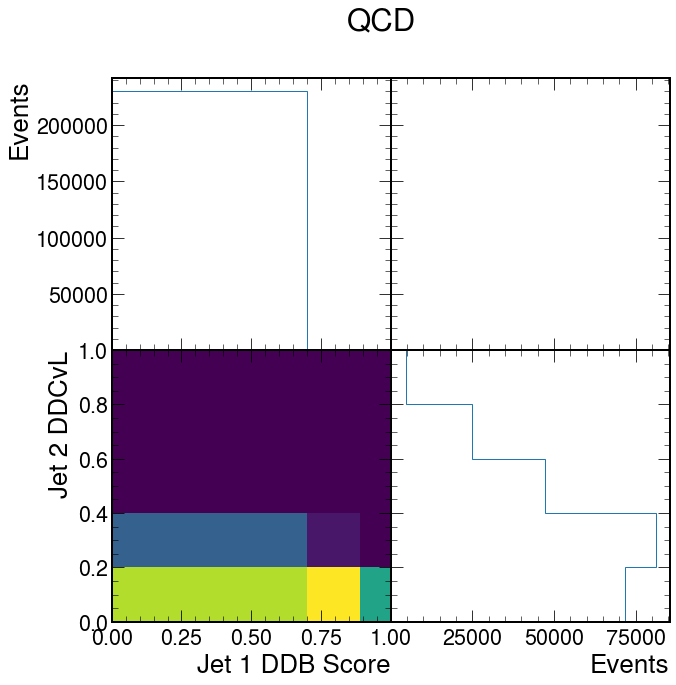

In [30]:
plot_2d_score("QCD", templates)

<AxesSubplot:xlabel='Jet 2 ddc score', ylabel='Events'>

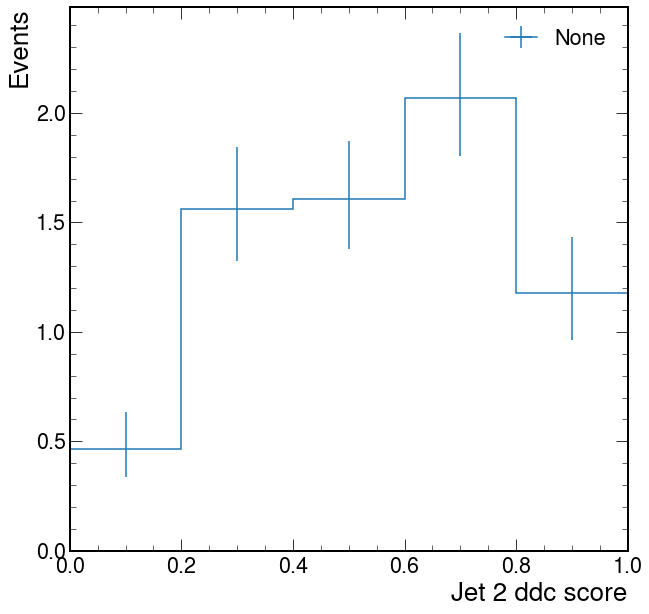

In [22]:
hist.plot1d(templates.sum('msd1','ddb1').integrate('process','ZH'))